In [1]:
#Imports

import h5py
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import pickle
import warnings

import tensorflow as tf
import tensorflow_datasets as tfds

from helper_functions import evaluate_measures, plot_history, plot_measures, load_measures
from HH_CNN import CNNDropConnect, CNNDropout, CNNPlotter
from RegNN import NNDropout, NNDropConnect, NNRegressor

from IPython.display import clear_output

#Global Variables
DATA_DIR = pathlib.Path("horse_or_human")
LABELS = {0: "horse", 1: "human"}
CHECKPOINT_PATH = "checkpoints"
FIG_PATH = "figs"
MEASURES_PATH = "measures"
%matplotlib inline
%load_ext autoreload
%autoreload 2

#Supress warning and error messages
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
tf.get_logger().setLevel("ERROR")
warnings.filterwarnings('ignore')

2022-03-13 19:06:01.633961: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-13 19:06:01.634061: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# 21D006 Project: Monte Carlo Dropout
<em>Authors</em>: Clinton Leung, David Ampudia Vicente

Deep learning has attracted much attention from researchers and practicioners in myriad fields of information engineering. These algorithms are able to learn powerful representations of the data, which can map points from high-dimensional spaces to an array of outputs. However, these mappings are all too often assumed accurate and taken blindly, which can have costly consequences in downstream code or real life applications. Deep Bayesian methods exist that account for this model uncertainty, but these are typically prohibitibely expensive, and thus impractical on large-dimensional problems. A more computationally efficient approach was put forth by Yarin Gal and coauthors in a well-cited 2015 [paper](http://proceedings.mlr.press/v48/gal16.pdf), where they suggest practicioners can repurpose the dropout regularization layer at testing time, computing Monte Carlo simulations of the same forward pass and using the variation generated due to the dropout layer to infer the model's uncertainty about a prediction. The authors show how such an approach approximates a Deep Gaussian process and is convenient to most deep learning applications.

The gist of MC Dropout is that it applies dropout both at train-time and at test-time. A baseline algorithm of can be introduced as follows

- Train a neural network $f_{\theta}(\mathbf{x})$ which contains Dropout layers. 
- At test time, run $T$ stochastic forward passes through $f_{\theta}(\mathbf{x})$ to obtain $T$ predictions for a given input $\mathbf{x}$.
- Conditional on the setup, combine the $T$ predictions to build estimates of uncertainty.


In this notebook, we present two sets of applications of the MC Dropout approach highlighted above, and also implement a generalization of the model as in [this paper](https://arxiv.org/abs/1906.04569). In a first application, we make use of a regression setup to lay out the building blocks of Monte Carlo dropout on both synthetic data and the dataset of CO2 emissions used in the seminal paper. Additionally, we investigate an extension to the original paper that allows the neural network to differentiate between <em>aleatoric</em> and <em>epistemic</em> uncertainty. In a second application, we turn to a classification setup, where softmax probabilities have traditionally been used as a proxy for uncertainty but which we show overestimate the confidence the model has on its predicitions.


## Regression

[Data CO2](https://github.com/yaringal/DropoutUncertaintyCaffeModels/tree/master/co2_regression/data)

In [2]:
with h5py.File('co2/co2_data.h5','r') as h5f:
    data = h5f[("data")][:]
    labels = h5f[("label")][:]
data_train = np.concatenate((data, labels), axis=1)
data_test = np.arange(-1.72, 3.51, 0.01).reshape(-1, 1)

In [3]:
def sine_data(n=2048, a:int=0, b:int=10, noise:float=0.3):
    x = np.linspace(a,b,n)
    y = 3*np.sin(x)
    y = y+np.random.normal(0,noise*np.abs(y),n)
    return y,x

y_train, X_train = sine_data(n=4096, a=-15, b=15)
y_test, X_test = sine_data(n=512, a=-5, b=10)

In [24]:
model = NNDropout(output=2, p_dropout=0.2)
loss = NNDropout.nll
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

model.compile(optimizer=optimizer, loss=loss, metrics=["mean_squared_error"])

model.fit(X_train, y_train, epochs=100, verbose=2, validation_split=0.2)

clear_output(wait=True)

Epoch 1/100


KeyboardInterrupt: 

In [38]:
y_test, X_test = sine_data(n=512, a=-15, b=17)

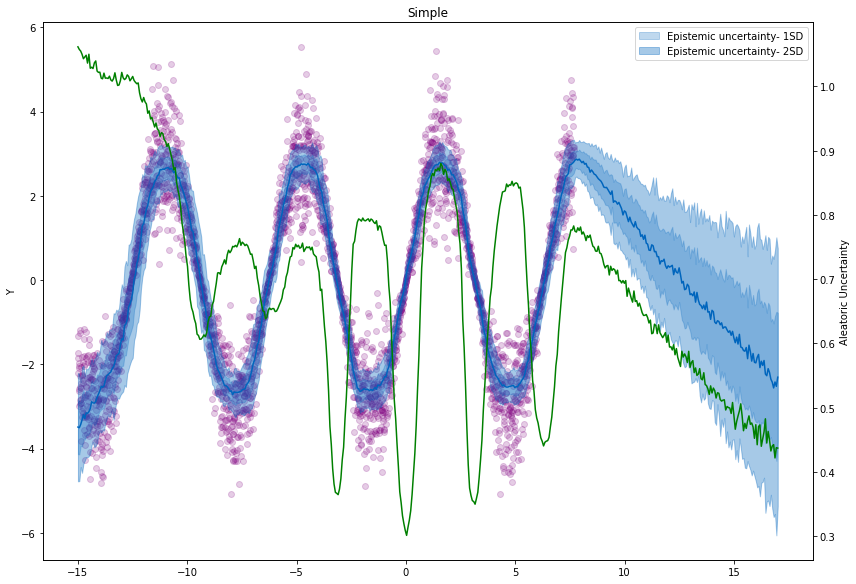

In [40]:
model_utils = NNRegressor(model=model)
model_utils.predict(X_test, mc=True, T=100)
figure = model_utils.plot(Xtrain=X_train[:-1000], Ytrain=y_train[:-1000], combined=False, title="Simple")

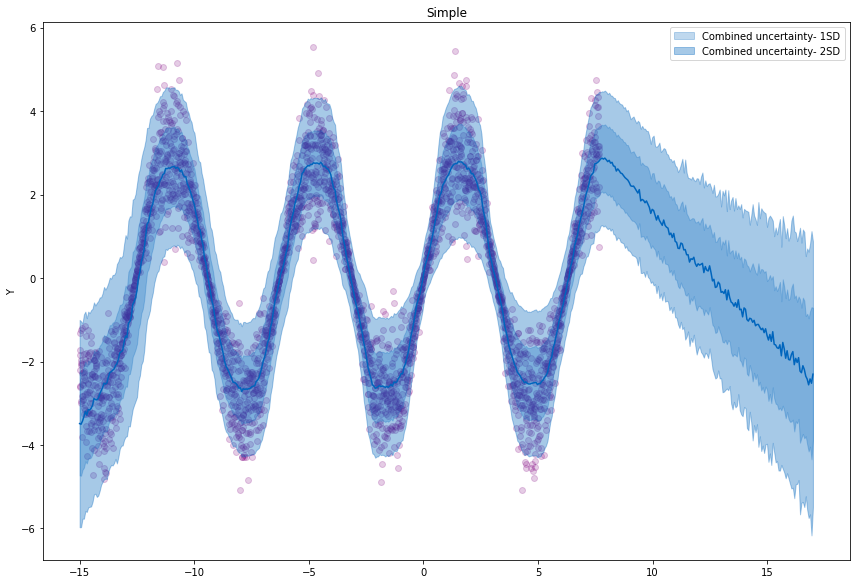

In [41]:
figure = model_utils.plot(Xtrain=X_train[:-1000], Ytrain=y_train[:-1000], combined=True, title="Simple")

## Classification

Here we get a synthetic dataset from [Laurence Moroney's website](https://laurencemoroney.com) and contains CGI generated horses and humans. Laurence's idea was to see if CGI generated images could be used to train a neural network to predict on real images afterwards. This is just an aside that is not part of our project here. We will instead use this synthetic data to demonstrate MC Dropout's ability to quantify model uncetainty. The softmax probability given is often wrongly interpreted as a measure of model uncertainty, but this is not apt. We will show this by using our trained network to classify images from two out of sample datasets. These datasets contain image of cats, dogs and flowers. An ideal uncertainty aware neural network should be able to know that it is uncertain with this out of sample data. To minimize running time the network has been trained and we are only reloading the weights. (See basic_dropout.py for the training script and details. See dropout_plotting.py for the evaluation of the prediction measures that were run to gather our data.) Let's start by loading all the relevant datasets. 

In [16]:
#Load the data
batch_size = 16
img_height = 300
img_width = 300
modelnames = ["dropout_p5", "dropout_p7", "dropconnect_p3", "dropconnect_p5"]

img_folder = tfds.folder_dataset.ImageFolder(
    root_dir=str(DATA_DIR),
    shape=(img_height, img_width, 3)
)

ds = img_folder.as_dataset(
    batch_size=batch_size,
    as_supervised=True,
)

train_ds = ds["train"].cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = ds["validate"].cache().prefetch(buffer_size=tf.data.AUTOTUNE)

#Load Out of Sample Data

val_iter = iter(val_ds)
catsdogs = iter(tfds.load("cats_vs_dogs", batch_size=16, as_supervised=True)["train"])
flowers = iter(tfds.load("oxford_flowers102", batch_size=16, as_supervised=True)["train"])

2022-03-13 19:59:48.991697: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Failed precondition: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".
2022-03-13 20:00:05.070321: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-13 20:00:05.071554: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-13 20:00:05.071572: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-13 20:00:05.071598: I tensorflow/stream_e

We fit four different models that use different dropout probabilities. One type of model uses MC Dropout and the other uses a variation known as MC Drop Connect. MC Dropout simply applies simple dropout to the inputs before each dense layer. Drop Connect is a generaliziation that applies these Bernoulli dropouts to every weight in each dense layer. The implementation of both of these can be seen in CustomDropout.py file. Here we load the saved history's of our training and find that MC Dropout has a slightly higher accuracy  at around 0.85 using 0.5 as the dropout probability and MC Drop Connect has a 0.81 accuracy using 0.3 as the dropout probability. When training we noticed that training was very sensitive to the relationship between the dropout probability and the learning rate. With too high of a learning rate and/or too high of a dropout probability we would often see no convergence; validation accuracy stayed at 0.5. We accounted for this by using a learning rate scheduler that reduces the learning rate by a certain factor if the validation accuracy did not improve after a certain number of epochs. The reesult of that and trying a few different probaility choices are the four models below. So, we continue by loading these two models as instances of our custom model classes and load our saved weights (see HH_CNN.py). 

In [6]:
#Check our model accuracies
for model in modelnames:
    with open(os.path.join(CHECKPOINT_PATH, f"{model}_history.pkl"), "rb") as infile:
        history = pickle.load(infile)
    print(f"{model} had a maximum validation accuracy of {max(history['val_accuracy'])}")


dropout_p5 had a maximum validation accuracy of 0.8515625
dropout_p7 had a maximum validation accuracy of 0.765625
dropconnect_p3 had a maximum validation accuracy of 0.8125
dropconnect_p5 had a maximum validation accuracy of 0.71484375


In [7]:
#Load the best models

mc_dropout = CNNDropout(num_classes=2, p_dropout=0.5)
mc_dropconnect = CNNDropConnect(num_classes=2, p_dropout=0.3)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, name="crossentropy")
mc_dropout.compile(optimizer=optimizer, loss=loss_fn)
mc_dropconnect.compile(optimizer=optimizer, loss=loss_fn)

mc_dropout.load_weights(os.path.join(CHECKPOINT_PATH, modelnames[0]))
mc_dropconnect.load_weights(os.path.join(CHECKPOINT_PATH, modelnames[2]))

Here we can load the histories of our corresponding models and plot the training history with respect to validation accuracy. We can see that we overfit a bit from the gap between the training and validation. We also see that we arrived at our maximum accuracy pretty quickly. 

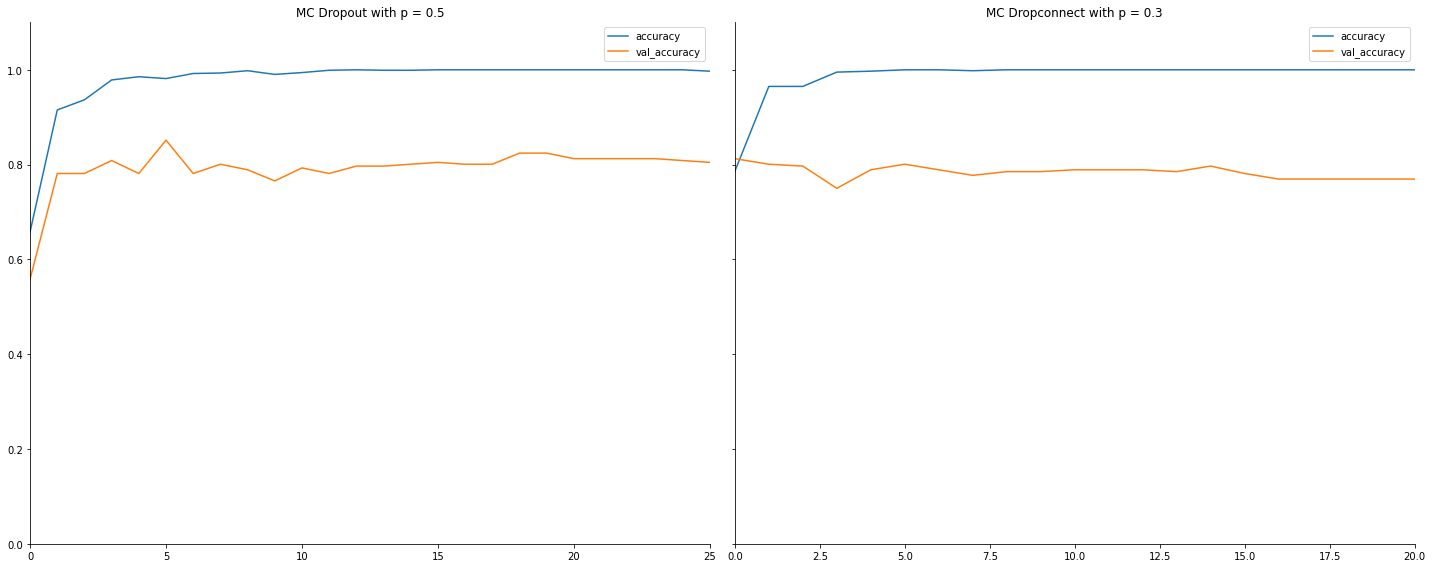

In [19]:
#Plot our training losses

with open(os.path.join(CHECKPOINT_PATH, f"{modelnames[0]}_history.pkl"), "rb") as infile:
    dropout_hist = pickle.load(infile)

with open(os.path.join(CHECKPOINT_PATH, f"{modelnames[2]}_history.pkl"), "rb") as infile:
    dropconnect_hist = pickle.load(infile)

#Plot our losses
fig, ax = plt.subplots(1,2, figsize=(20, 8), tight_layout=True, sharey=True)
plot_history(dropout_hist, ["accuracy", "val_accuracy"], "MC Dropout with p = 0.5", ax=ax[0])
plot_history(dropconnect_hist, ["accuracy", "val_accuracy"], "MC Dropconnect with p = 0.3", ax=ax[1])

Now let's take a look atour datasets. We load a batch of each dataset and instantiate our CNNPlotter class (see HH_CNN.py) and plot some of the images. Notice that the cats and dogs and flowers datasets do not have images that match the sizing correctly of the horse and human dataset. This makes our out of sample data even more disimilar from our the data that our neural network is trained on! We also note that flowers are intuitively more dissimilar to horses and humans. 

In [21]:
#Load our plotter class and sample batches of our data
horse_human_batch = next(val_iter)
cats_dogs_batch = next(catsdogs)
flowers_batch = next(flowers)
cnn_plotter = CNNPlotter()

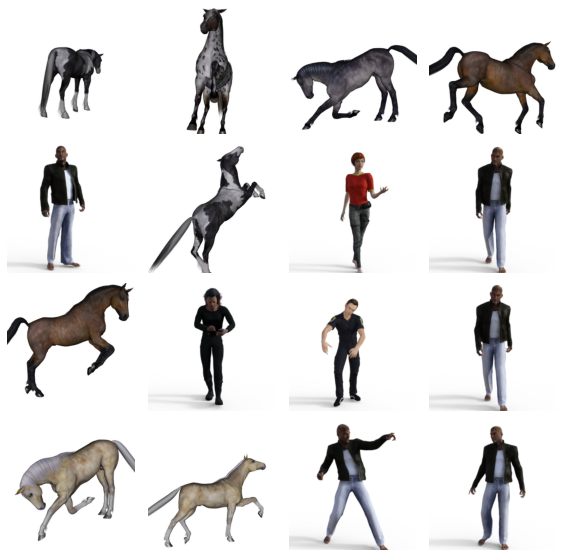

In [23]:
cnn_plotter.plot_batch(horse_human_batch[0], 4, 4, figsize=(8,8))

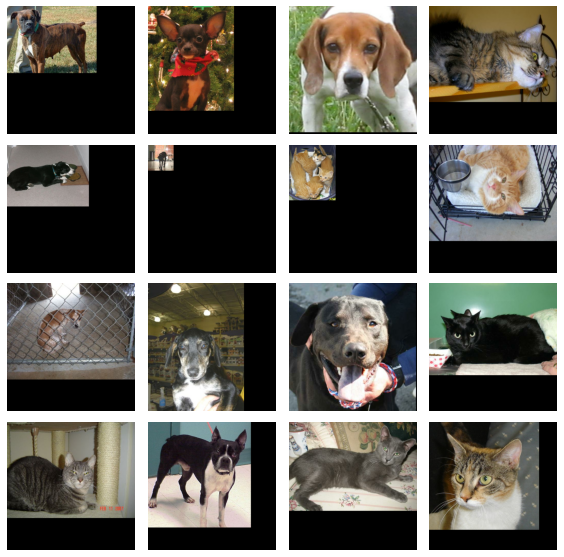

In [25]:
cnn_plotter.plot_batch(cats_dogs_batch[0], 4, 4, figsize=(8, 8))

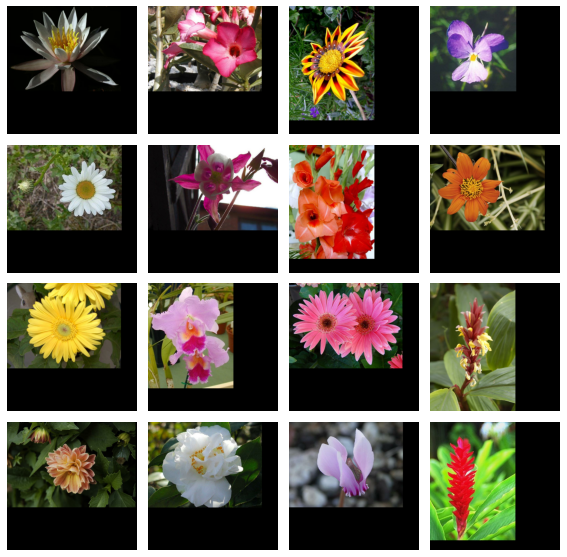

In [24]:
cnn_plotter.plot_batch(flowers_batch[0], 4, 4, figsize=(8, 8))

In [ ]:
#Load plotters and plote some predictions

#Skip this cell if you do not want to repredict. Figures have been saved and can be loaded in the next cell. 

T=500
softmax_plotter = CNNPlotter(model=mc_dropout, labels=LABELS)
dropout_plotter = CNNPlotter(model=mc_dropout, labels=LABELS)
dropconnect_plotter = CNNPlotter(model=mc_dropconnect, labels=LABELS)

def plot_model_predictions(batch_iterator, T):
    images, _ = next(batch_iterator)
    softmax_plotter.plot_batch(images, 4, 4, figsize=(16,16), title="Softmax", predict=True)
    dropout_plotter.plot_batch(images, 4, 4, figsize=(16,16), title="MC Dropout", predict=True, mc=True, T=T)
    dropconnect_plotter.plot_batch(images, 4, 4, figsize=(16,16), title="MC DropConnect", predict=True, mc=True, T=T)
    figs = [softmax_plotter.fig, dropout_plotter.fig, dropconnect_plotter.fig]
    return figs

horse_human_predictions = plot_model_predictions(val_iter, T)
cats_dogs_predictions = plot_model_predictions(catsdogs, T)
flowers_predictions = plot_model_predictions(flowers, T)

datasets = ["horse", "cats", "flowers"]

def save_figs(figs, dataset_name):
    modelnames = ["softmax", "mcdropout", "dropconnect"]
    for fig, modelname in zip(figs, modelnames):
        fig.savefig(os.path.join("figs", f"{modelname}_{dataset_name}_prediction.png"), facecolor="white", transparent=False)
        print(f"{modelname}_{dataset_name}_prediction.png Saved!")

for data_name, predictions in zip(datasets, [horse_human_predictions, cats_dogs_predictions, flowers_predictions]):
    save_figs(predictions, data_name)

Here we will plot some predictions of the models and see how they fare. For each dataset we have randomly predicted a single batch of the data using each of our three methods: the naive model, the MC Dropout model and the MC Dropconnect model. T regulates the number of forward passes that the dropout model will make. The recommendation is to make somewhere between 300-500 forward passes. This is a bit computationally high, so we have run it with T = 500 and saved the figs, so you can see the results below. For each image we report the softmax score that was used and the uncertainty quantification. For the naive model the uncertainty quantification will always read 0 since the model is not uncertainty aware in anyways and is completely confident in its prediction. For the MC Dropout and MC Dropconnect model, the softmax scores represent the mean of T number of stochastic passes. The uncertainty measure for MC Dropout and MC DropConnect uses the mutual information criterion that is typically used to estimate the uncertainty given by our predictions. Mutual information between two random variables X and Y is given by:

$H[P(y|x)] = - \sum_{y \in Y} P(y|x) log P(y|x)$ 
$I(X,Y) = H[P(Y)] - E_{P(X)}H[P(Y|X)]$

Where in our case y is one of the two classes and Y is the set of classes. We simply make T stochastic passes and take the average to get P(y|x). The mutual information criterion can be interpreted as the amount of information we would gain about the model parameters if we were to receive a label y for a new point x. The lowest value of mutual information is 0 and it is theoretically unbounded upwards, although it increases logarithmnically and hence fairly slowly. A value of 0 would claim that there would be no extra information gained by learning the true label over what the model can predict and hence imply no uncertainty. On the other hand higher values of mutual information would then imply more uncertainty claiming that knowledge of the true label would give us more information about the model parameters. Smith breaks down measures of uncertainty in this context in his paper [Understanding Measures of Uncertainty for Adversarial Example Detection](http://auai.org/uai2018/proceedings/papers/207.pdf).

Although this is just one single batch, we can already see that the naive model typically has a softmax score of 1 for its out of sample predictions which is why it is a mistake to use softmax as a proxy for model uncertainty, noting that model uncertainty is distinct from epistemic uncertainty which is an irreducible uncertainty that stems from the data. The canonical example of aleatoric vs epistemic uncertaint is the so-called coin flip example where if given a fair coin, the epistemic uncertainty of the resultant coin flip would be 0.5, yet the aleatoric uncertainty would be 0. In our analogy, being given out of sample data would be akin to being given an unfair coin. The naive model continiues to report the softmax (the epistemic uncertainty) with no awareness or way of becoming aware that the coin might be unfair. On the other hand the MC Dropout and MC DropConnect models have some ability of quantifying this uncertainty of whether or not they actually hold a fair coin, and this is measured by the mutual information criterion given a number of stochastic passes. This is the more accurate way of considering these uncertainty scores. 

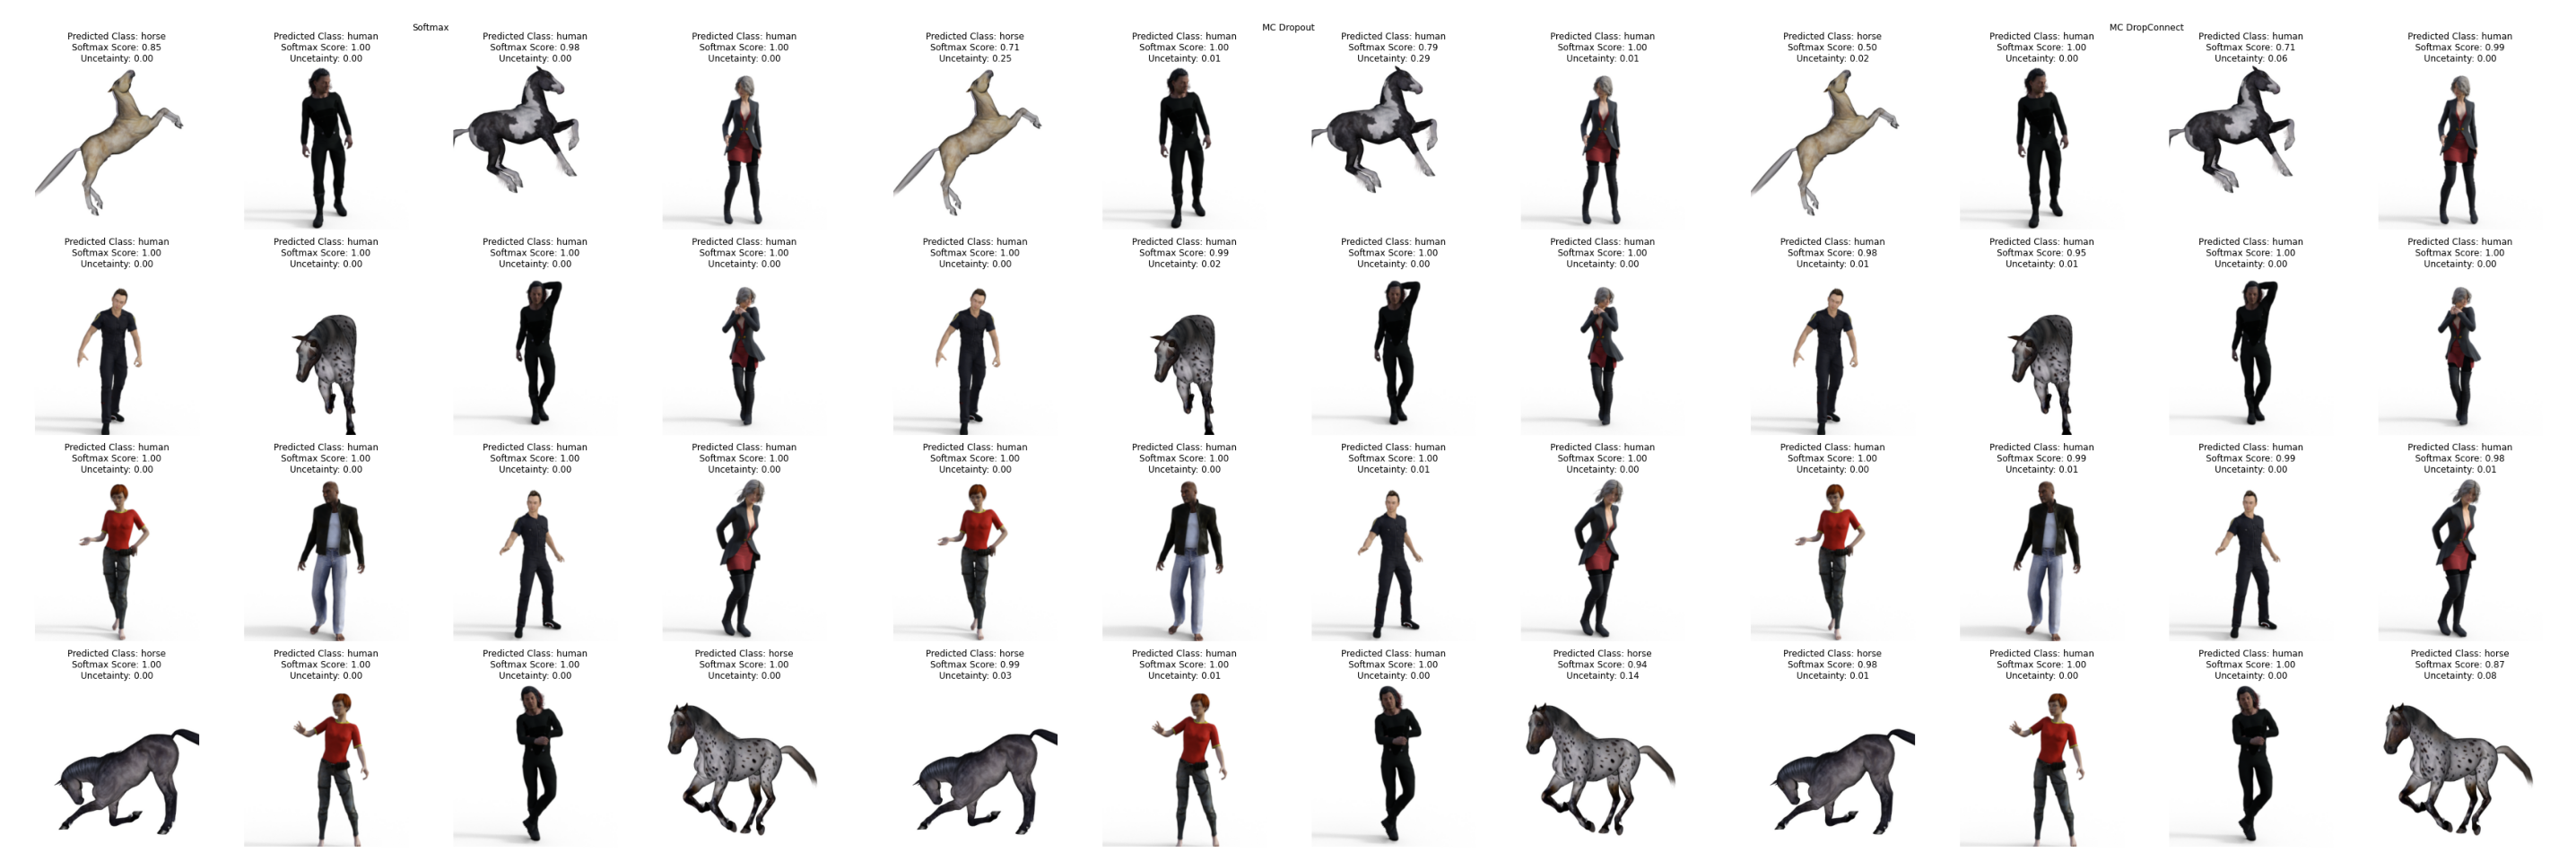

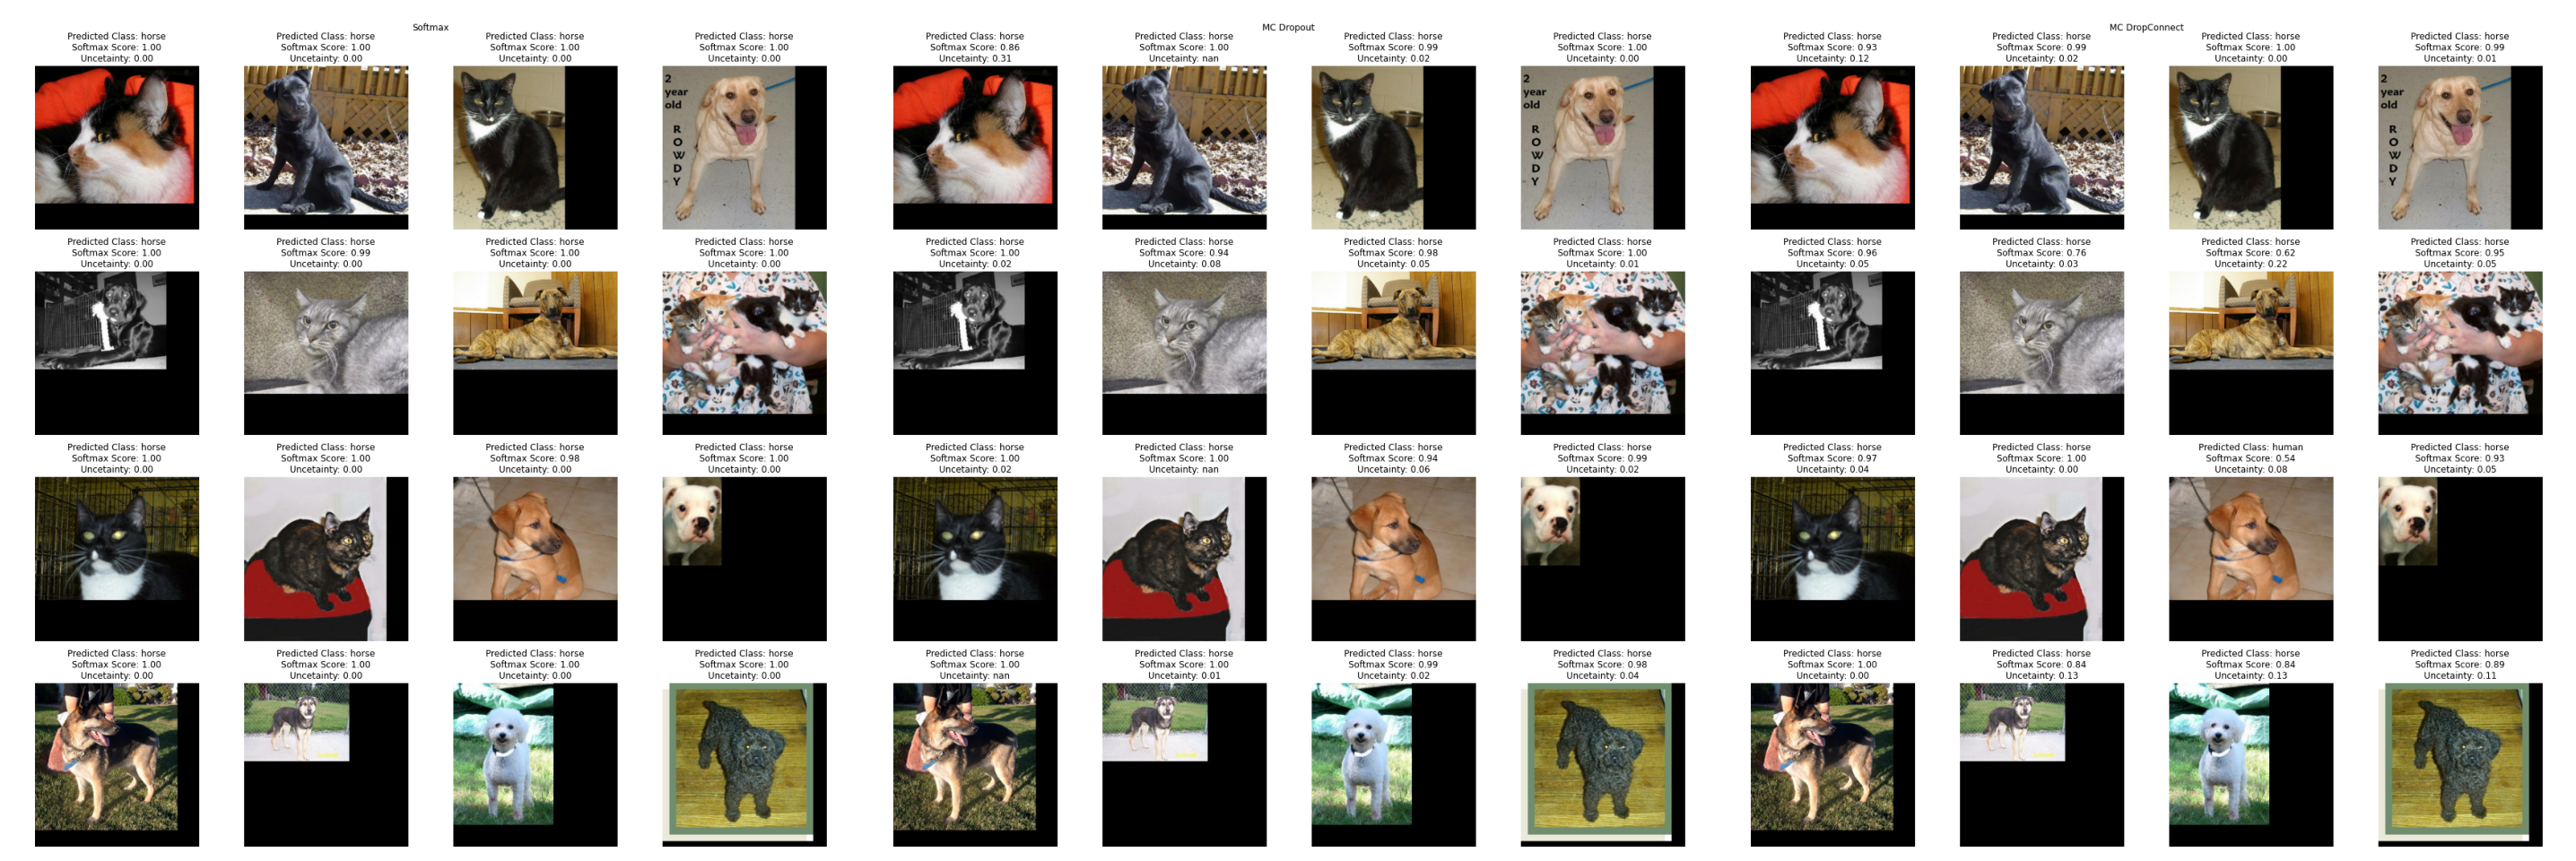

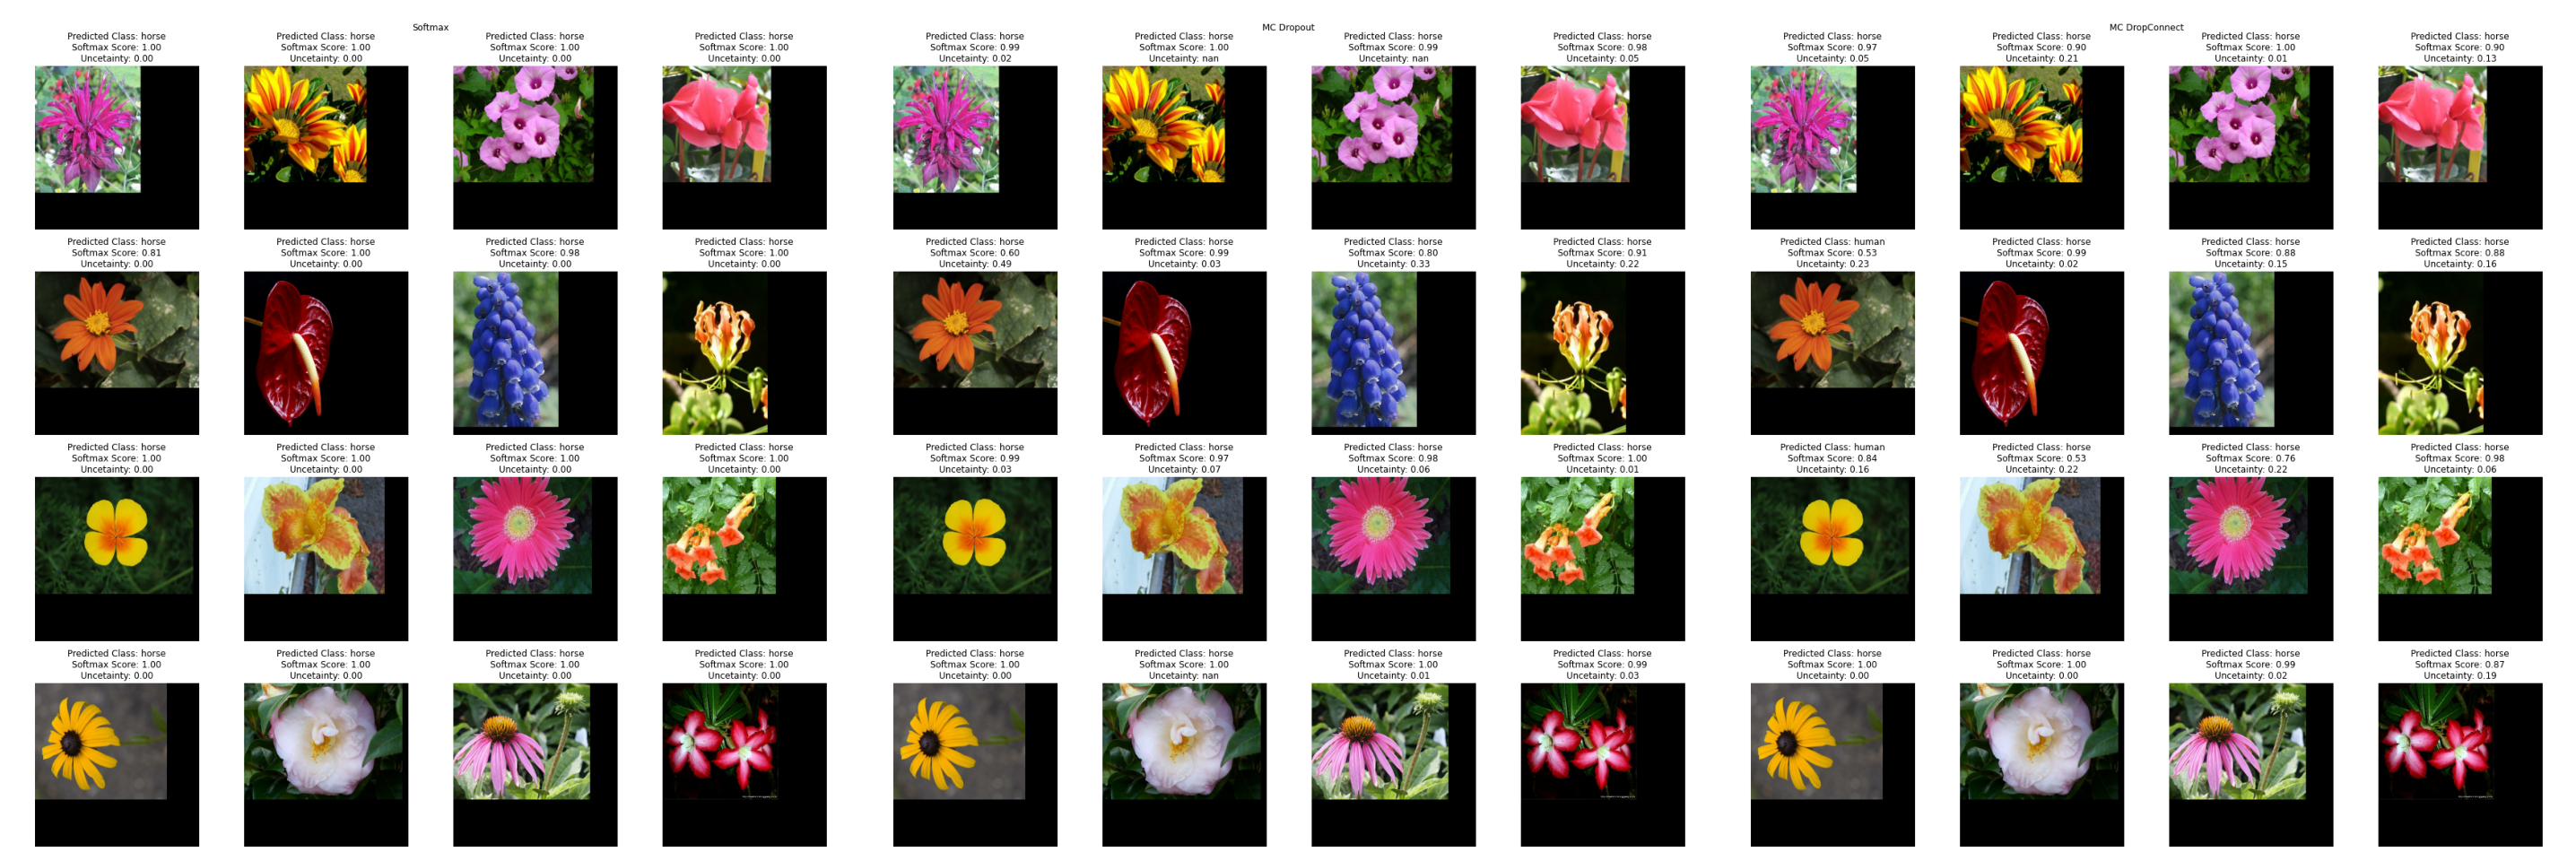

In [29]:
#Load presaved prediction figures

datasets = ["horse", "cats", "flowers"]
modelnames = ["softmax", "mcdropout", "dropconnect"]

prediction_figs = []
for dataset in datasets:
    fig, ax = plt.subplots(1, 3, figsize=(40, 80), tight_layout=True)
    for ax, model in zip(ax.ravel(), modelnames):
        img = mpimg.imread(os.path.join("figs", f"{model}_{dataset}_prediction.png"))
        ax.imshow(img)
        ax.set_axis_off()
    prediction_figs.append(fig)

#The figs folder has larger versions of these figures if not easily viewed


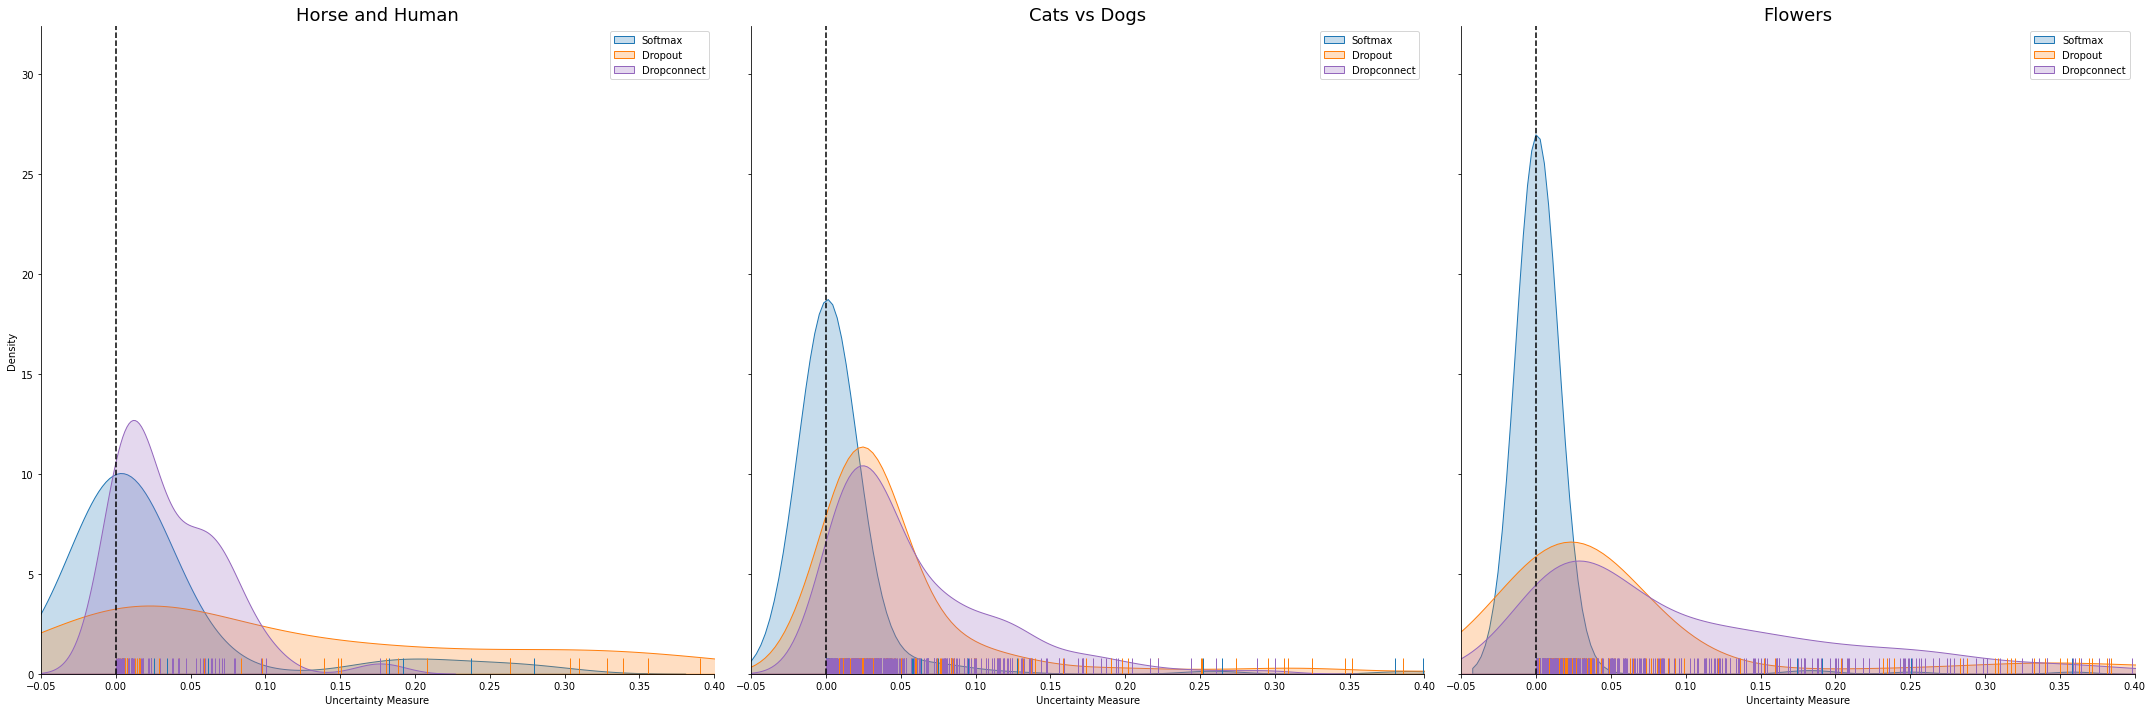

In [11]:
#Load Prediction Measures

models = ["softmax", "dropout", "dropconnect"]
datasets = ["horse", "cat", "flower"]
types = ["correct", "wrong"]
colors = ["tab:blue", "tab:orange", "tab:purple", "tab:olive"]
data_titles = {"horse": "Horse and Human", "cat": "Cats vs Dogs", "flower": "Flowers"}

measures = load_measures(MEASURES_PATH, models, datasets)

Text(0.35, 3.35, 'Horse and Human Classification')

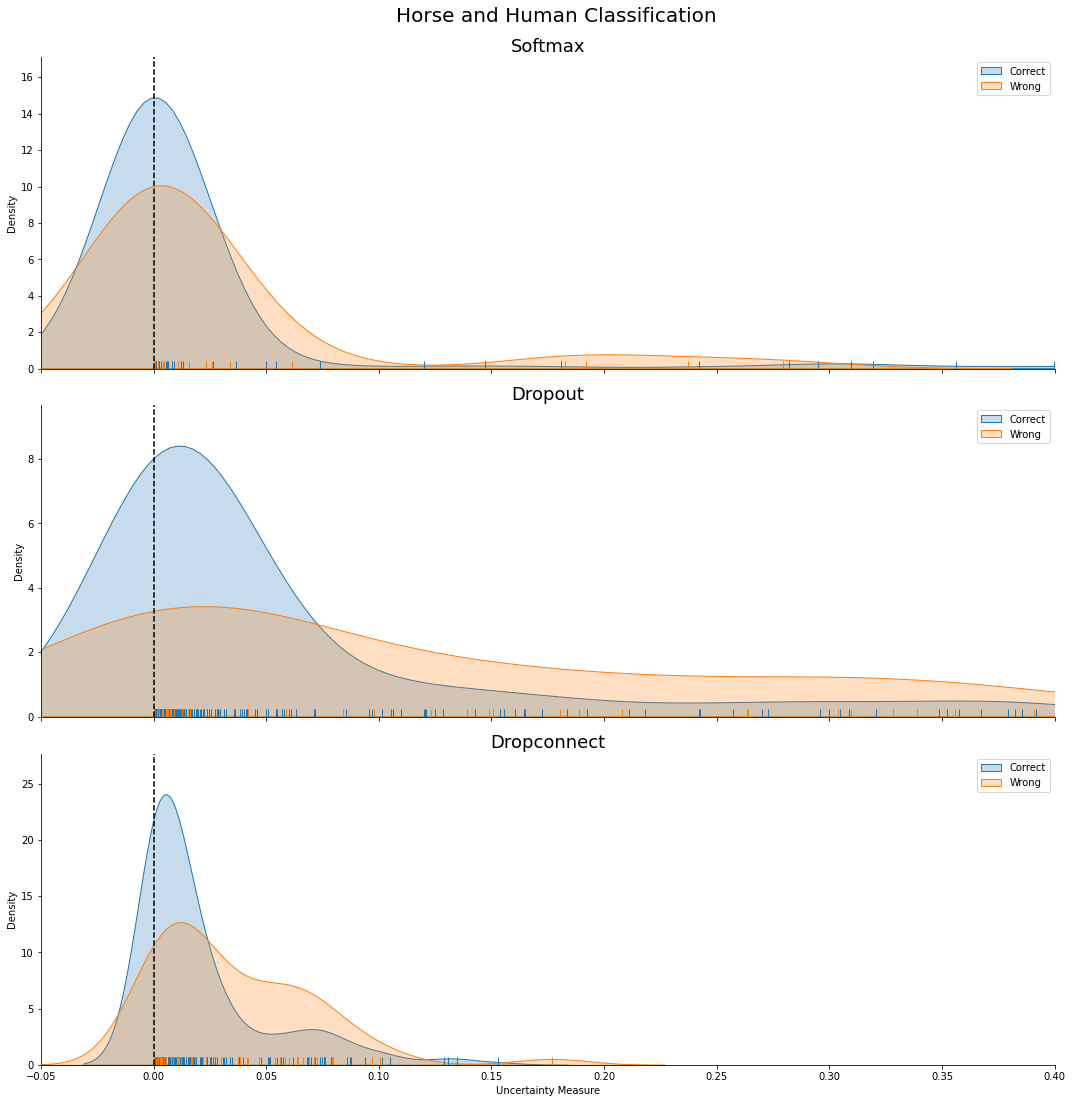

In [13]:

comp_fig, axs = plt.subplots(3, 1, figsize=(15, 15), tight_layout=True, sharey=False, sharex=True)
for ax, model in zip(axs.ravel(), models):
    plot_measures(
        measures, 
        scores=[f"{model}_horse_{t}" for t in types], 
        colors=colors, 
        labels=[t.capitalize() for t in types], 
        ax=ax, 
        title=model.capitalize()
    )
comp_fig.text(x=0.35, y = 3.35, s="Horse and Human Classification", fontsize=20, transform=ax.transAxes)

Finally, we ran the model to predict 16 batches of 16 images for our three datasets: the validation set, the cats and dogs set and the flowers set. We ran 300 stochastic forward passes for each dropout model and then made naive predictions with the softmax by using no stochasticicty in a single forward pass. We plot the distirbution of their corresponding uncertainty measure. We plotted 1 - softmax probability as a pseudo uncertainty measure and the comparison of this with the mutual information gain measure is to be taken with a large grain of salt as this is just to give an idea of what someone might perceive as uncertainty by heuristically using the softmax. The Dropout and Dropconnect distributions are directly comparable. 

The dotted black line indicates 0 and the x-axis starts a bit before 0 for purely aesthetic reasons as it is not possible to take values below 0. The ‘rug’ at the bottom is a compressed visualization of the underlying histogram from which these kernel densities are estimated from. We can see in the horse and human dataset that the softmax is largely predicting with high certainty even though we know the true validation accuracy is not as high as that would suggest. By contrast, both Dropconnect and Dropout are a bit shifted towards the right. The interesting here is Dropout has a much larger spread of uncertainty values. 

Here we compare how the different uncertainty measures for correct and incorrect predictions of the. We can see that MCDropout and MCDropConnect are somehow a bit more uncertain of their predictions and in particular a bit more uncertain when they are wrong based on the dispersion of their distributions as compared to the dispersion of the naive softmax distributions. Unfortunately the centering of their distributions leaves room for improvement and we do not see as much separation as we would want for an uncertainty aware model. MCDropConnect here is slightly better than MCDropout. 

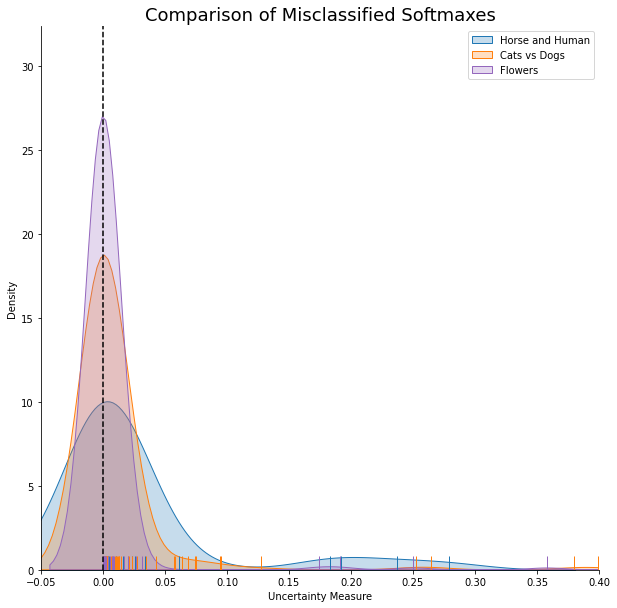

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_measures(
    measures,
    scores = [f"softmax_{data}_wrong" for data in datasets],
    colors=colors,
    labels = [data_titles[data] for data in datasets],
    title="Comparison of Misclassified Softmaxes",
    ax=ax
)

Here we can compare the softmax scores given by a standard model, to show how wrong it would be to use softmax scores as a proxy for model uncertainty. Here the model is increasingly "certain" in the face of out of sample predictions. This is in contrast to above where we can see that MC Dropout and MC Drop Connect are increasingly uncertain as we feed the model samples that are more and more out of sample so to speak. 

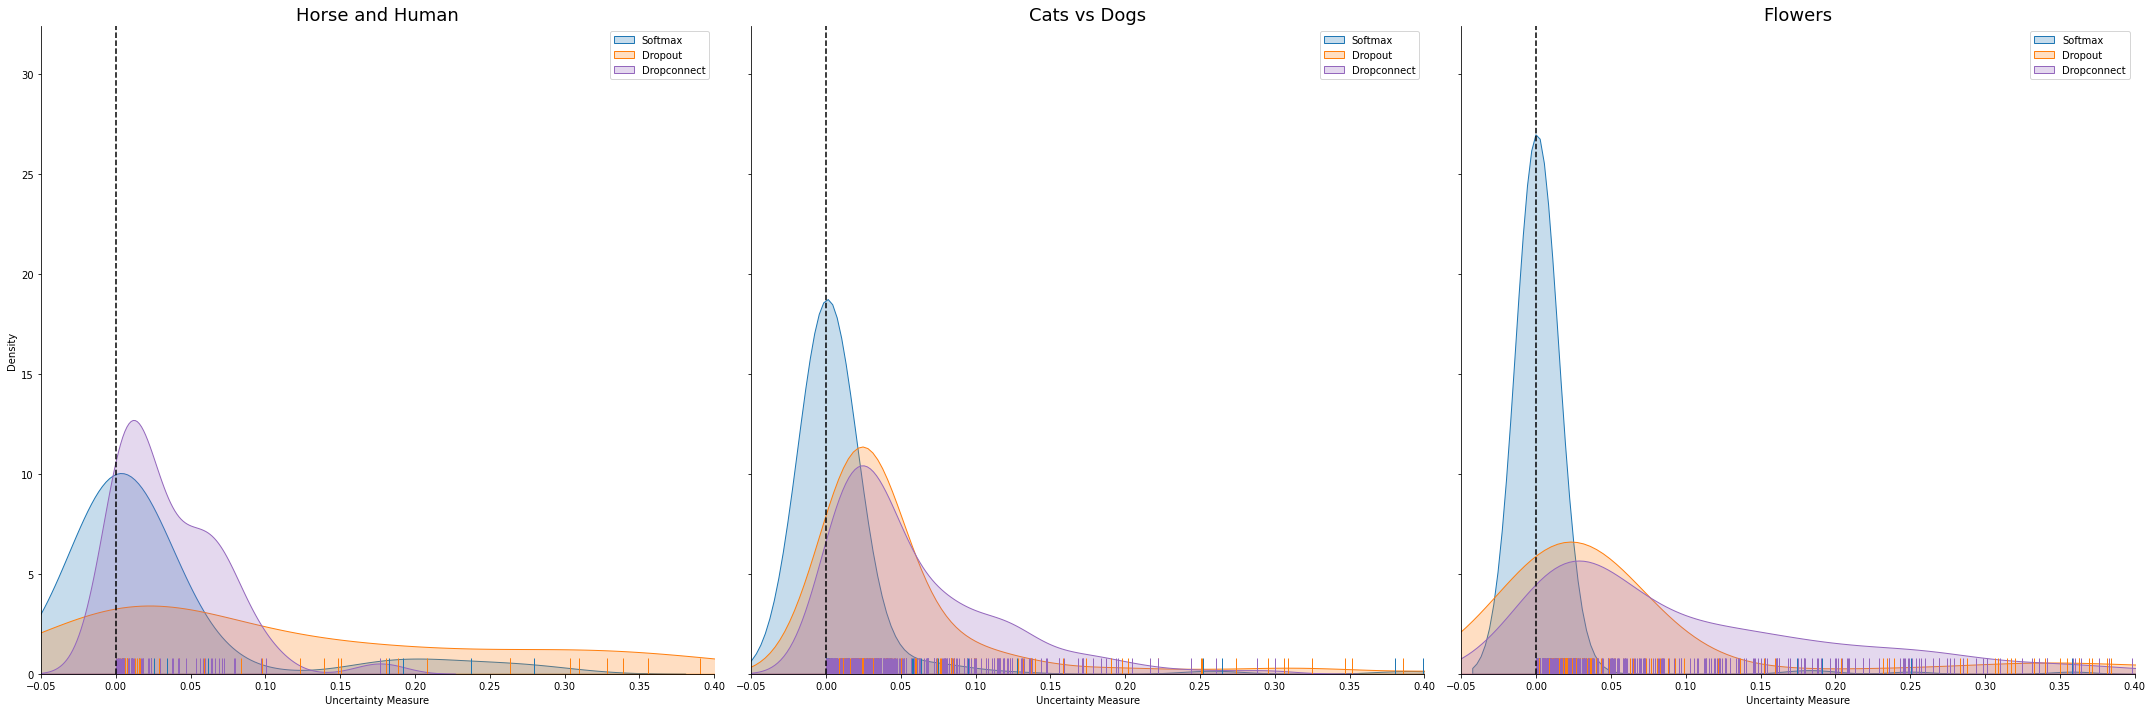

In [12]:
#Plot Prediction Measures
fig, axs = plt.subplots(1, 3, figsize=(30, 10), tight_layout=True, sharey=True)
dataset_figs = []
for ax, data in zip(axs, datasets):
    scores = [f"{m}_{data}_wrong" for m in models]
    labels = [m.capitalize() for m in models]
    plot_measures(measures, scores, colors, labels, title=data_titles[data], ax=ax)

Rather than erroneously comparing the naive softmax measure with the mutual information criterion, it is more important to compare the changes of these distributions across the datasets. The datasets are arranged from the validation set of the in sample data, an out of sample set of cats and dogs, and an out of sample set of flowers which are somehow even less similar to horses and humans than cats and dogs. Counterintuitively, we can see that the softmax scores of the naive model are purportedly more certain as we become more and more out of sample. This is why a softmax score cannot be interpreted as a form of model uncertainty. It has the complete opposite effect of what we wish for. For both MC Dropout and MC DropConnect we can see that the center of their distributions move further and further away from zero as we get more and more out of sample which is a desirable property. Once again we note that the mutual information criterion grows very slowly at first due to its log scale. Nonethless we would have hoped for higher levels of uncertainty for out of sample data. The distributions for MCDropout and MCDropconnect also become more and more dispersed which is desirable except for the distribution for the misclassified validation set for MC Dropout. For that reason, in this example we would prefer the uncertainty measures of MCDropConnect to MCDropout. 